# 21cm Line Emission Simulations using RASCIL

## This notebook demonstrates how to run a 21cm line emission simulation, to obtain visibilities and dirty images, and create a mosaic of pointings with and without primary beams.

In [1]:
!export HDF5_USE_FILE_LOCKING='FALSE'

In [2]:
from datetime import datetime, timedelta
from pathlib import Path

import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
from typing import List
from ska_sdp_datamodels.image.image_model import Image as RASCILImage

from karabo.data.external_data import HISourcesSmallCatalogDownloadObject
from karabo.imaging.image import Image, ImageMosaicker
from karabo.imaging.imager_rascil import RascilDirtyImagerConfig
from karabo.simulation.interferometer import FilterUnits, InterferometerSimulation
from karabo.simulation.line_emission import (
    CircleSkyRegion,
    line_emission_pipeline,
)
from karabo.simulation.beam import (
    generate_gaussian_beam_data,
    gaussian_beam_fwhm_for_frequency,
)
from karabo.simulation.observation import Observation
from karabo.simulation.sky_model import SkyModel
from karabo.simulation.telescope import Telescope
from karabo.simulator_backend import SimulatorBackend
from karabo.util.file_handler import FileHandler

%matplotlib inline

In [3]:
# Image details
npixels = 2048
image_width_degrees = 3
cellsize_radians = np.radians(image_width_degrees) / npixels

# The number of time steps is then determined as total_length / integration_time.
observation_length = timedelta(seconds=14400)  # 14400 = 4hours
integration_time = timedelta(seconds=14400)

output_base_directory = Path(
    FileHandler().get_tmp_dir(
        prefix="line-emission-",
        purpose="Example line emission simulation",
    )
)

Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk for Example line emission simulation


In [4]:
# Define observation pointings
pointings = [
    CircleSkyRegion(
        radius=2 * u.deg, center=SkyCoord(ra=20, dec=-30, unit="deg", frame="icrs")
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=20, dec=-31.4, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-30, unit="deg", frame="icrs"),
    ),
    CircleSkyRegion(
        radius=2 * u.deg,
        center=SkyCoord(ra=21.4, dec=-31.4, unit="deg", frame="icrs"),
    ),
]

In [5]:
# Primary beam settings
should_apply_primary_beam = False

# Create interferometer simulation
if should_apply_primary_beam:
    beam_type = "Gaussian beam"
    # Options: "Aperture array", "Isotropic beam", "Gaussian beam", "VLA (PBCOR)"
    gaussian_fwhm = 50  # Degrees
    gaussian_ref_freq = 8e8  # Hz
else:
    beam_type = "Isotropic beam"
    gaussian_fwhm = 0
    gaussian_ref_freq = 0

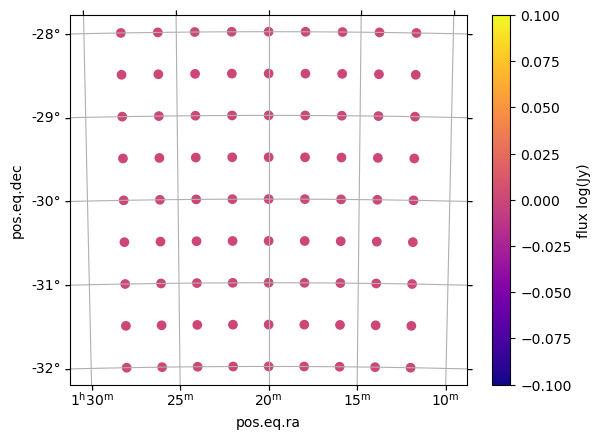

In [6]:
# Load test sky with sources
sky = SkyModel.sky_test_LE()

# Load example catalog of sources
# catalog_path = HISourcesSmallCatalogDownloadObject().get()
# sky = SkyModel.get_sky_model_from_h5_to_xarray(path=catalog_path)

sky.explore_sky(phase_center=(20, -30), wcs_enabled=True)

In [7]:
# Define observation channels and duration
observation = Observation(
    start_date_and_time=datetime(2000, 3, 20, 12, 6, 39),
    length=observation_length,
    number_of_time_steps=int(
        observation_length.total_seconds() / integration_time.total_seconds()
    ),
    start_frequency_hz=7.1e8,  # start of redshift-bin you want to measure
    frequency_increment_hz=2e7,
    number_of_channels=4,  # on how many frequency channels you want to observe
)

In [8]:
# Instantiate interferometer
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

## Simulation: compute visibilities and dirty images (first, without primary beam effects)

In [9]:
# Run pipeline which computes the visibilities and dirty images
backend_to_dirty_images = {}

dirty_imager_config = RascilDirtyImagerConfig(
    imaging_npixel=npixels,
    imaging_cellsize=cellsize_radians,
)

for simulator_backend, telescope_name in ((SimulatorBackend.RASCIL, "MID"),):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    visibilities, dirty_images = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images[simulator_backend] = dirty_images


print("Done with line emission pipelines")


# To use OSKAR change RascilDirtyImagerConfig to DirtyImagerConfig and SimulatorBackend.RASCIL to SimulatorBackend.OSKAR

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...


Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p3.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM

## Visualization of dirty images (and mosaics)

In [10]:
# Create mosaics of pointings for each frequency channel
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)


# Add all mosaics across frequency channels to create one final mosaic image
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-5mSSbYj6Km for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-D6UxgK3G1l for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-ex2aWcD2i5 for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-hPfanGczPn for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-0FnVlThJRP for restored fits-path


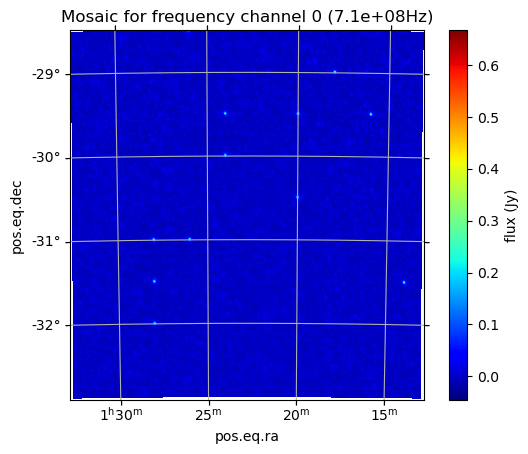

In [11]:
%matplotlib inline
# Plot the mosaic for the first frequency channel
backend_to_mosaics[SimulatorBackend.RASCIL][0].plot(
    block=True,
    title=f"Mosaic for frequency channel 0 ({observation.start_frequency_hz:.1e}Hz)",
)

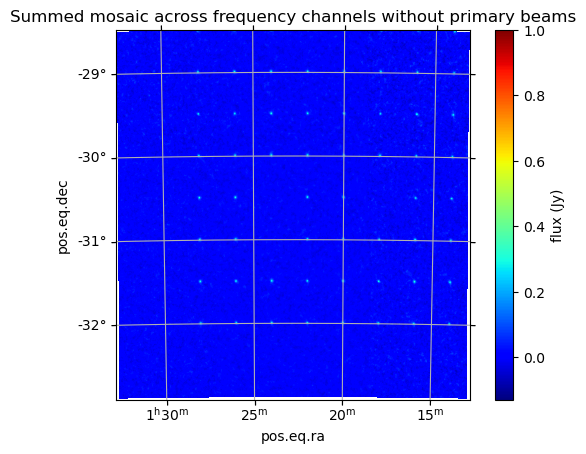

In [12]:
%matplotlib inline
# Plot the mosaics summed over all frequency channels
backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True,
    vmax=1,
    title="Summed mosaic across frequency channels without primary beams",
)

# Primary Beam Effects

## We instantiate different interferometers (with / without primary beam effects), and provide primary beams (Gaussian, in this example) to the `line_emission_pipeline`

## NOTE!
- RASCIL ignores the `gaussian_*` parameters in `InterferometerSimulation`, and instead uses the `primary_beams` array provided into `line_emission_pipeline`

In [13]:
# Instantiate interferometers
interferometer = InterferometerSimulation(
    time_average_sec=10,
    ignore_w_components=True,
    uv_filter_max=10000,
    uv_filter_units=FilterUnits.Metres,
    use_gpus=True,
    station_type="Isotropic beam",
    gauss_beam_fwhm_deg=0,
    gauss_ref_freq_hz=0,
    use_dask=False,
)

# If you want to work with OSKAR you need to change the station_type to "Gaussian beam" and change the parameters gauss_beam_fwhm_deg=2 and gauss_ref_freq=7e8

## Generate data for primary beams (2D np.array for each frequency channel)
### RASCIL supports custom primary beams -> here, we use Gaussian beams
### For OSKAR the primary beam is created in the InterferometerSimulation

In [14]:
primary_beams: List[RASCILImage] = []

# Compute frequency channels
frequency_channel_starts = np.linspace(
    observation.start_frequency_hz,
    observation.start_frequency_hz
    + observation.frequency_increment_hz * observation.number_of_channels,
    num=observation.number_of_channels,
    endpoint=False,
)

In [15]:
# Here we create a sample beam (Gaussian)
# as a 2D np.array of shape (npixels, npixels)

for frequency in frequency_channel_starts:
    fwhm_degrees = gaussian_beam_fwhm_for_frequency(frequency)
    fwhm_pixels = fwhm_degrees / np.degrees(dirty_imager_config.imaging_cellsize)
    primary_beam = generate_gaussian_beam_data(
        fwhm_pixels=fwhm_pixels,
        x_size=dirty_imager_config.imaging_npixel,
        y_size=dirty_imager_config.imaging_npixel,
    )
    primary_beams.append(primary_beam)

To create a primary beam using eidos 'from eidos_beam_generator import eidos_beam_generator' und then convert the fits into 2D np.arrays

## We then run the simulations with and without primary beams, and compare the resulting dirty images

In [16]:
backend_to_dirty_images_without_primary_beams = {}

for simulator_backend, telescope_name in (
    (SimulatorBackend.RASCIL, "MID"),  # For OSKAR change to SimulatorBackend.OSKAR
):
    telescope = Telescope.constructor(telescope_name, backend=simulator_backend)

    # Compute visibilities without primary beam

    (
        visibilities_without_primary_beam,
        dirty_images_without_primary_beam,
    ) = line_emission_pipeline(
        output_base_directory=output_base_directory,
        pointings=pointings,
        sky_model=sky,
        observation_details=observation,
        telescope=telescope,
        interferometer=interferometer,
        simulator_backend=simulator_backend,
        dirty_imager_config=dirty_imager_config,
        primary_beams=None,
    )

    backend_to_dirty_images_without_primary_beams[
        simulator_backend
    ] = dirty_images_without_primary_beam

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...


Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p3.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM

In [17]:
# Compute visibilities with primary beams

backend_to_dirty_images_with_primary_beams = {}

(
    visibilities_with_primary_beam,
    dirty_images_with_primary_beam,
) = line_emission_pipeline(
    output_base_directory=output_base_directory,
    pointings=pointings,
    sky_model=sky,
    observation_details=observation,
    telescope=telescope,
    interferometer=interferometer,
    simulator_backend=simulator_backend,
    dirty_imager_config=dirty_imager_config,
    primary_beams=primary_beams,
)

backend_to_dirty_images_with_primary_beams[
    simulator_backend
] = dirty_images_with_primary_beam

Selected backend: SimulatorBackend.RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk directory if it does not exist yet.
Computing visibilities...
Processing frequency channel 0...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p1.MS to format MS
Processing pointing 2...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p2.MS to format MS
Processing pointing 3...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f0_p3.MS to format MS
Processing frequency channel 1...
Processing pointing 0...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-zAAAnnUGOk/visibilities_f1_p0.MS to format MS
Processing pointing 1...
Matched path /tmp/karabo-STM-jennifer-QnmZy3ppP6/line-emission-

In [18]:
# Create mosaics of pointings for each frequency channel without primary beam
mosaicker = ImageMosaicker()

backend_to_mosaics = {}

for simulator_backend, dirty_images in backend_to_dirty_images.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images[index_freq])
        backend_to_mosaics[simulator_backend].append(mosaic)


# Add all mosaics across frequency channels to create one final mosaic image without primary beams
backend_to_summed_mosaics = {}

for simulator_backend, mosaics in backend_to_mosaics.items():
    summed_mosaic = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics[simulator_backend] = summed_mosaic

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-xuhiVstFCZ for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-cB0Xl0W7yt for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-ziOCZXikQB for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-JreYtQiGJX for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-aNAjCd8wXu for restored fits-path


In [19]:
# Create mosaics of pointings for each frequency channel with primary beam
backend_to_mosaics_primary_beam = {}

for (
    simulator_backend,
    dirty_images_with_primary_beam,
) in backend_to_dirty_images_with_primary_beams.items():
    print(f"Computing mosaic for  simulator_backend = { simulator_backend.name }")
    backend_to_mosaics_primary_beam[simulator_backend] = []

    for index_freq in range(observation.number_of_channels):
        mosaic, _ = mosaicker.mosaic(dirty_images_with_primary_beam[index_freq])
        backend_to_mosaics_primary_beam[simulator_backend].append(mosaic)

# Add all mosaics across frequency channels to create one final mosaic image with primary beams
backend_to_summed_mosaics_primary_beam = {}

for simulator_backend, mosaics in backend_to_mosaics_primary_beam.items():
    summed_mosaic_primary = Image(
        data=sum(m.data for m in mosaics),
        header=mosaics[0].header,
    )
    backend_to_summed_mosaics_primary_beam[simulator_backend] = summed_mosaic_primary

Computing mosaic for  simulator_backend = RASCIL
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-OfOAHJSYyq for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-nmj6InR62a for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-BLU7IXTnsF for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-1xC8tHCqdy for restored fits-path
Creating /tmp/karabo-STM-jennifer-QnmZy3ppP6/Image-praKeGC4b0 for restored fits-path


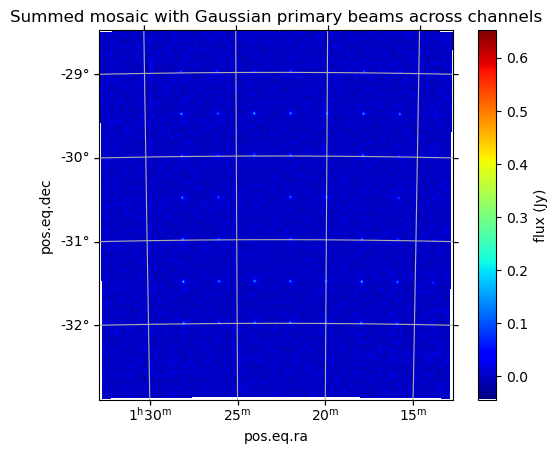

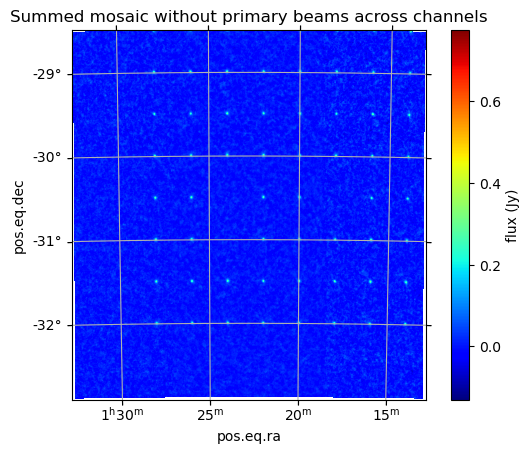

In [20]:
%matplotlib inline
backend_to_summed_mosaics_primary_beam[SimulatorBackend.RASCIL].plot(
    block=True, title="Summed mosaic with Gaussian primary beams across channels"
)

backend_to_summed_mosaics[SimulatorBackend.RASCIL].plot(
    block=True, title="Summed mosaic without primary beams across channels"
)